In [1]:
import re
import pandas as pd
from wordcloud import WordCloud
import nltk
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
stopwords = nltk.corpus.stopwords.words('english')

In [3]:


def remove_punctuation(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(
        "https?:\/\/\s\S+",
        "",
        text,
    )
#     text = re.sub(r"[^@#\w\s]", "", text)
    return text

In [4]:
df = pd.read_csv('irony-labeled.csv')

In [5]:
df['comment_text'].apply(remove_punctuation)[0]

"I suspect atheists are projecting their desires when they imagine Obama is one of their number.  Does anyone remember the crazy preacher with whom he was associated?  http://www. examiner. com/article/obama-and-wright-throw-each-other-under-the-bus  I can understand a career politician in the USA needing to feign belief to get elected, but for that purpose I'd imagine a more vanilla choice of church.     He's not an atheist.  He's not a liberal either."

Text(0.5, 1.0, 'Ironic Comments')

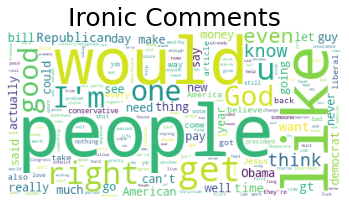

In [6]:
text_ironic = ' '.join(df.comment_text[df['label'] == 1])
wc_ironic = WordCloud(background_color='white',stopwords=stopwords).generate(text_ironic)
plt.imshow(wc_ironic)
plt.axis('off')
plt.title('Ironic Comments',fontsize=25)

Text(0.5, 1.0, 'Regular Comments')

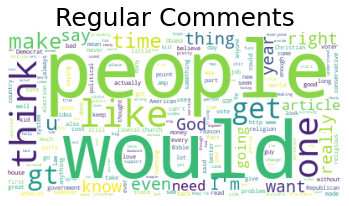

In [7]:
text = ' '.join(df.comment_text[df['label'] == -1])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Regular Comments',fontsize=25)

In [8]:
#Lista de sentenças irônicas e regulares
# sents_ironic = [item.split() for item in df.comment_text[df['label'] == 1]]
# sents_regular = [item.split() for item in df.comment_text[df['label'] == -1]]
# sents_ironic[0]

In [36]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['im'])
STOPWORDS = set(STOPWORDS)

def preprocess(sent):

    def convert(word):
        word = re.sub(r"\W+", "", word)
        # Verifica se é um número.
        try:
            _ = float(word)
            return '<num>'
        except:
            pass

        # Verifica se é uma palavra.
        if word.isalpha():
            lower = word.lower()
            return '<stop>' if lower in STOPWORDS else lower

        # Caso contrário, é pontuação ou estranho.
        return '<weird>'

    processed = [convert(word) for word in sent]
    forbidden_words = set(('<num>', '<stop>', '<weird>'))
    return [word for word in processed if word not in forbidden_words]

In [37]:
#Lista de sentenças irônicas e regulares
sents_ironic = [preprocess(item.strip().split()) for item in df.comment_text[df['label'] == 1]]
sents_regular = [preprocess(item.strip().split()) for item in df.comment_text[df['label'] == -1]]

### DOC2VEC

### LDA

In [38]:
import pickle
from gensim.corpora import Dictionary

In [39]:
%%time
dictionary_ironic = Dictionary(sents_ironic)
dictionary_regular = Dictionary(sents_regular)

Wall time: 64 ms


In [40]:
from gensim.models.ldamulticore import LdaMulticore
def model_dict(sents, filename):
    dictionary = Dictionary(sents)
    corpus = [dictionary.doc2bow(sent) for sent in sents]
    
    pickle.dump(corpus, open(f'{filename}_corpus.pkl', 'wb'))
    dictionary.save(f'{filename}_dictionary.gensim')
    
    NUM_TOPICS = 6
    ldamodel = LdaMulticore(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=30)

    return corpus, dictionary, ldamodel

In [41]:
corpus_ironic, dictionary_ironic, lda_model_ironic = model_dict(sents_ironic, 'sents_ironic')
corpus_regular, dictionary_regular, lda_model_regular = model_dict(sents_regular, 'sents_regular')

In [42]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

In [43]:
def display_model(corpus, dictionary, ldamodel):  
    lda_display = pyLDAvis.gensim_models.prepare(
        ldamodel,
        corpus,
        dictionary,
        sort_topics=False,
    )
    return pyLDAvis.display(lda_display)


In [44]:
display_model(corpus_ironic, dictionary_ironic, lda_model_ironic)

In [45]:
display_model(corpus_regular, dictionary_regular, lda_model_regular)